In [1]:
# We'll use some of the key concepts to create a neural network for image classification 
# of items of clothing. Step one will be to normalize the input images, 
# and we'll use NDArray operations to calculate the channel mean. 
# We'll create a function to evaluate the performance of networks on the data, 
# and construct a couple of different neural networks for image classification.

# Import the required libraries
import mxnet as mx
import numpy as np
import os
from matplotlib import pyplot as plt
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.data.vision import FashionMNIST
from pathlib import Path
from tqdm import tqdm

In [2]:
# 1)--> Data (& NDArray Operations)
# use the in-built dataset called FashionMNIST which is a variant of the commonly 
# used MNIST dataset.
# Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 
# examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated 
# with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for 
# the original MNIST dataset for benchmarking machine learning algorithms. 
# It shares the same image size and structure of training and testing splits.
test_dataset = FashionMNIST(train=False).transform_first(transforms.ToTensor())

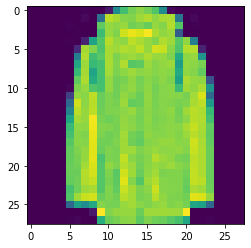

In [3]:
sample_idx = 123
sample_data, sample_label = test_dataset[sample_idx]
plt.imshow(sample_data[0].asnumpy()) # # 0 for first and only channel (since greyscale).

In [4]:
# One improvement step before passing to the network is normalization: i.e. shifting and
# scaling the pixel values so that they are zero-centred on average and have unit variance.

# Methods of Normalization:
# 1: pixelwise, where each "pixel" should have a unit normal distribution of values.
# 2: channelwise, where each "channel" should have a unit normal distribution of values.

# One of the first steps in the pixelwise approach is to calculate an 'average image'
# from the dataset. Using a sample of 1024 images.
test_dataloader = mx.gluon.data.DataLoader(test_dataset, shuffle=False, batch_size=1024)
for data, label in test_dataloader:
    break
print(data.shape)

(1024, 1, 28, 28)


In [5]:
# This function should calculate the 'average image'
# param batch: batch of images in NCHW layout
# type batch: mx.nd.NDArray
# return: average image in CHW layout
def get_average_image_from_batch(batch):
    return (mx.nd.mean(batch, axis=0))
    raise NotImplementedError()

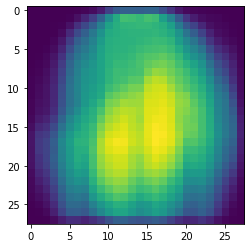

In [6]:
average_image = get_average_image_from_batch(data)
assert average_image.shape == (1, 28, 28)
plt.imshow(average_image[0].asnumpy()) # 0 for the first and only channel (greyscale)

In [7]:
# Using the average image calculated above, we should implement a function to perform the 
# pixelwise normalization.
# param sample: sample image in CHW layout
# type sample: mx.nd.NDArray
# param average_image: average image of the dataset in CHW layout
# type average_image: mx.nd.NDArray
# return: pixelwise normalized image in CHW layout

def subtract_average_image(sample, average_image):
    return sample-average_image
    raise NotADirectoryError

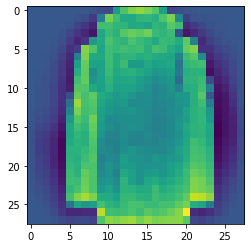

In [8]:
normalized_sample_data = subtract_average_image(sample_data, average_image)
assert normalized_sample_data.shape == (1, 28, 28)
np.testing.assert_array_almost_equal(normalized_sample_data.asnumpy(), (sample_data - average_image).asnumpy())
plt.imshow(normalized_sample_data[0].asnumpy()) # 0 for the first and only channel (since greyscale)

In [9]:
# Channelwise Normalization.
# This function should return the average value for each channel across the images 
# of the batch of multi-channel inputs.
# param batch: batch of images in NCHW layout
# type batch: mx.nd.NDArray
# return: channel averages in C layout
# rtype: mx.nd.NDArray
def get_channel_average_from_batch(batch):
    return (mx.nd.mean(batch, axis=1, exclude=True))
    raise NotImplementedError()

In [10]:
channel_average = get_channel_average_from_batch(data).asscalar()
print(channel_average)
assert isinstance(channel_average, np.float32)
np.testing.assert_almost_equal(channel_average, 0.28757906, decimal=5)

test_averages = mx.nd.array([1,2,3,4])
test_input = mx.nd.reshape(test_averages, shape=(1,4,1,1)) * mx.nd.ones(shape=(10,4,25,25))
test_channel_average = get_channel_average_from_batch(test_input)
np.testing.assert_array_almost_equal(test_averages.asnumpy(), test_channel_average.asnumpy())

0.28757906


In [11]:
# Using this channel average, we can use the Normalize transform to apply this 
# to all samples in our dataset as they are loaded
channel_std = 0.31
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(channel_average, channel_std)
])

In [12]:
train_dataset = FashionMNIST(train=True).transform_first(transform)
test_dataset = FashionMNIST(train=False).transform_first(transform)
train_dataloader = mx.gluon.data.DataLoader(train_dataset, shuffle=True, batch_size=128)
test_dataloader = mx.gluon.data.DataLoader(train_dataset, shuffle=False, batch_size=128)

In [13]:
# 2)--> Metrics
# Here, we will implement a function to test the prediction quality of networks. Using
# Accuracy as the evaluation metric.
# The following functions takes a network and a dataloader (with test data) and returns an
# MXNet Metric that has been updated with labels and predictions.
# Calculate the accuracy of the network on the data given by the dataloader.
# return: updated metric
# rtype: mx.metric.EvalMetric
from mxnet import metric
def calculate_accuaracy(network, dataloader):
    accuracy = metric.Accuracy()
    for data, labels in tqdm(dataloader):
        preds = network(data)
        accuracy.update(labels = labels,preds= preds)
    return accuracy

In [14]:
test_network = mx.gluon.nn.Dense(units=10)
test_network.initialize()
metric = calculate_accuaracy(test_network, test_dataloader)
print(metric.get())
isinstance(metric, mx.metric.EvalMetric)
assert metric.name == 'accuracy'
assert metric.num_inst == 60000

100%|██████████| 469/469 [00:05<00:00, 82.88it/s]

('accuracy', 0.08005)


In [15]:
# 3)--> Network
# Here, we will implement a couple of different image classification networks and train 
# them on the FashionMNIST dataset. 
def train(network, dataloader):
    softmax_cross_entropy = mx.gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = mx.gluon.Trainer(network.collect_params(), 'sgd', {'learning_rate': 0.1})
    for data, label in tqdm(dataloader):
        with mx.autograd.record():
            output = network(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

In [16]:
# The first model should be a sequential network with 3 layers.
# The first layer should have 16 hidden units.
# The second layer should have 8 hidden units.
# The last layer should the correct number of output units for the classification task at hand.
from mxnet.gluon import nn
network = nn.Sequential()
network.add(
    nn.Dense(16, activation='relu'),
    nn.Dense(8, activation='relu'),
    nn.Dense(10)
)

In [17]:
assert isinstance(network, mx.gluon.nn.Sequential)
assert len(network) == 3
assert isinstance(network[0], mx.gluon.nn.Dense)
assert network[0].act.name.endswith('relu')
assert network[0].weight.shape[0] == 16
assert isinstance(network[1], mx.gluon.nn.Dense)
assert network[1].act.name.endswith('relu')
assert network[1].weight.shape[0] == 8
assert isinstance(network[2], mx.gluon.nn.Dense)
assert network[2].act is None
assert network[2].weight.shape[0] == 10

In [18]:
# With the defined network, we should initialize its parameters using the Xavier method.
initializer = mx.initializer.Xavier()
network.initialize(initializer)

In [20]:
assert isinstance(initializer, mx.initializer.Xavier)

In [21]:
# checking the network summary, the network has 12786 trainable parameters
network.summary(data)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                           (1024, 1, 28, 28)               0
        Activation-1                    <Symbol dense1_relu_fwd>               0
        Activation-2                                  (1024, 16)               0
             Dense-3                                  (1024, 16)           12560
        Activation-4                    <Symbol dense2_relu_fwd>               0
        Activation-5                                   (1024, 8)               0
             Dense-6                                   (1024, 8)             136
             Dense-7                                  (1024, 10)              90
Parameters in forward computation graph, duplicate included
   Total params: 12786
   Trainable params: 12786
   Non-trainable params: 0
Shared params in forward computation graph: 0
Unique 

In [22]:
# Calculate accuracy of the network on the data given by the dataloader
# param network: network to be tested
# type network: mx.gluon.Block
# param dataloader: dataloader for test data
# type datalaoder: mx.gluon.data.DataLoader
# return updated metric
# rtype: mx.metric.EvalMetric

from mxnet import metric 
def calculate_accuracy(network, dataloader):
    accuracy = metric.Accuracy()
    for data, labels in tqdm(dataloader):
        preds = network(data)
        accuracy.update(labels = labels,preds = preds)
    return accuracy

In [23]:
# Using the calculate_accuracy function to evaluate the performance of this architecture.
train(network, train_dataloader)
metric = calculate_accuaracy(network, test_dataloader)
print(metric.get())

100%|██████████| 469/469 [00:05<00:00, 84.10it/s]

('accuracy', 0.8136666666666666)


In [24]:
# Trying different architecture that uses convolutional and max pooling layers.
# We define another sequential network which has 5 layers in total
# 1. Convolutional Layer (32 channels, 3x3 kernel and ReLU activation)
# 2. Max Pooling Layer (2x2 kernel and 2x2 stride)
# 3. Convolutional Layer (16 channels, 3x3 kernel and ReLU activation)
# 4. Max Pooling Layer (2x2 kernel and 2x2 stride)
# 5. Dense Layer (10 output units)
network = nn.Sequential()
network.add(
    nn.Conv2D(32, (3,3), activation='relu'),
    nn.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    nn.Conv2D(16, (3,3), activation='relu'),
    nn.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    nn.Dense(10)
)

In [25]:
assert isinstance(network, mx.gluon.nn.Sequential)
assert len(network) == 5
assert isinstance(network[0], mx.gluon.nn.Conv2D)
assert network[0].act.name.endswith('relu')
assert network[0].weight.shape[0] == 32
assert isinstance(network[1], mx.gluon.nn.MaxPool2D)
assert isinstance(network[2], mx.gluon.nn.Conv2D)
assert network[2].act.name.endswith('relu')
assert network[2].weight.shape[0] == 16
assert isinstance(network[3], mx.gluon.nn.MaxPool2D)
assert isinstance(network[4], mx.gluon.nn.Dense)
assert network[4].act is None
assert network[4].weight.shape[0] == 10

In [26]:
# checking the network summary, the network has 8954 trainable parameters 
# (30% fewer parameter than the previous one)
network.initialize(init=initializer)
network.summary(data)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                           (1024, 1, 28, 28)               0
        Activation-1                     <Symbol conv0_relu_fwd>               0
        Activation-2                          (1024, 32, 26, 26)               0
            Conv2D-3                          (1024, 32, 26, 26)             320
         MaxPool2D-4                          (1024, 32, 13, 13)               0
        Activation-5                     <Symbol conv1_relu_fwd>               0
        Activation-6                          (1024, 16, 11, 11)               0
            Conv2D-7                          (1024, 16, 11, 11)            4624
         MaxPool2D-8                            (1024, 16, 5, 5)               0
             Dense-9                                  (1024, 10)            4010
Parameters in forward comput

In [28]:
# Calculate the accuracy of the network
# param network: network to be tested
# type network: mx.gluon.Block
# param dataloader: dataloader for test data
# type dataloader: mx.gluon.data.DataLoader
# return updated metric
# rtype: mx.metric.EvalMetric

from mxnet import metric
def calculate_accuracy(network, dataloader):
    accuracy = metric.Accuracy()
    for data, labels in tqdm(dataloader):
        preds = network(data)
        accuracy.update(labels = labels,preds = preds)
    return accuracy

In [29]:
# Finally, evaluate the network performance
train(network, train_dataloader)
metric = calculate_accuracy(network, test_dataloader)
print(metric.get())

100%|██████████| 469/469 [00:10<00:00, 46.41it/s]

('accuracy', 0.8418166666666667)
